In [1]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import matplotlib.pyplot as plt
import qutip
import matplotlib.colors as colors
import scipy as sp

import utils, optimization, visualization

In [2]:
def plot_wigner_fucntion(result, trace):
    # --- 1. Setup indicies and grid ---
    num_plots = 12
    indices = np.linspace(0, len(result.states) - 1, num_plots, dtype=int)
    lim_axis = 9
    xvec = np.linspace(-lim_axis, lim_axis, 100)

    # --- 2. Computer Wigner functions ---
    wigner_data = []
    for i in indices:
        rho = result.states[i]      
        rho0 = qutip.ptrace(rho, trace)    # only keep subsystem you want (ex: qumode)
        W = qutip.wigner(rho0, xvec, xvec) 
        wigner_data.append(W)

    # --- 3. Normalize color scale across all plots ---
    W_all = np.array(wigner_data)
    vmax = np.max(np.abs(W_all))
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)

    # --- 4. Create subplot grid ---
    fig, axes = plt.subplots(2, 6, figsize=(14, 4))
    cmap = 'seismic'
    times = np.array(result.times)

    # --- 5. Fill each subplot ---
    for idx, (ax, W, i) in enumerate(zip(axes.flat, wigner_data, indices)):
        cf = ax.contourf(xvec, xvec, W, 100, norm=norm, cmap=cmap)
        ax.set_title(r't = {:.2}'.format(times[indices][idx]))

    # --- 6. Clean up axis ticks/labels ---
    if idx < 6:
        ax.set_xticks([])
        ax.set_xlabel('')
    if idx % 6 != 0:
        ax.set_yticks([])
        ax.set_ylabel('')

    # --- 7. Add shared colorbar ---
    cbar_ax = fig.add_axes((0.92, 0.15, 0.02, 0.7))
    fig.colorbar(cf, cax=cbar_ax)

    # --- 8. Adjust layout & show ---
    plt.subplots_adjust(wspace=0.02, hspace=0.01, right=0.9)
    plt.show()

In [3]:
# Create Morse Potential Through My Code
morse_potential = utils.MorsePotential(
    mass = 1,
    de = 1.0, 
    b = 0.5, 
    x0 = 0.5,
    hbar = 1
)

backend = utils.Gates(
    dim = 40,
    time = 1
)

morse_hamiltonian = backend.partial_morse(morse_potential)

In [4]:
# --- 1. Qumode system size & operators ---
N = 40 
a = qutip.destroy(N)    # annihilation operator
adag = a.dag()          # creation operator

# --- 2. Quadrature operators ---
x = (a + adag)/np.sqrt(2)   # position-like operator X
p = -1j*(a - adag)/np.sqrt(2) # momentum-like operator P

# --- 3. Potential parameters ---
D = 1.0     # dissociation energy scale
beta = 0.5  # potential parameter (width)
x0 = 0.5    # equilibrium displacement

# --- 4. Morse Hamiltonian ---
H = p**2 + D * (qutip.qeye(N) - (-beta*(x - x0*qutip.qeye(N))).expm())**2

# --- 5. Initial state ---
psi_init = qutip.coherent(N, 1)

# --- 6. Time evolution grid ---
times = np.linspace(0.0, 1.0, 20)

# --- 7. Manual time evolution ---
states = []
U_morse_opt = []

for n in range(0, len(times)):
    U_morse = (-1j * H * times[n]).expm()  # compute unitary U(t) = e^{-iHt}
    psi_current = U_morse * psi_init       # evolve the initial state
    states.append(psi_current)             # store state at time t
    U_morse_opt.append(U_morse)            # store unitary operator

# --- 8. Fake result object ---
class FakeResult:
    pass

result = FakeResult()
result.states = states  # type: ignore
result.times = times    # type: ignore


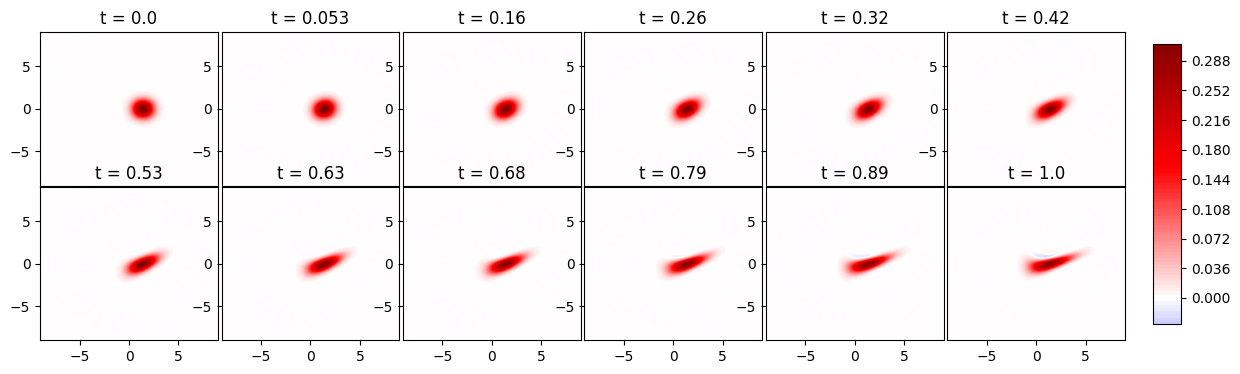

In [5]:
plot_wigner_fucntion(result, 0)

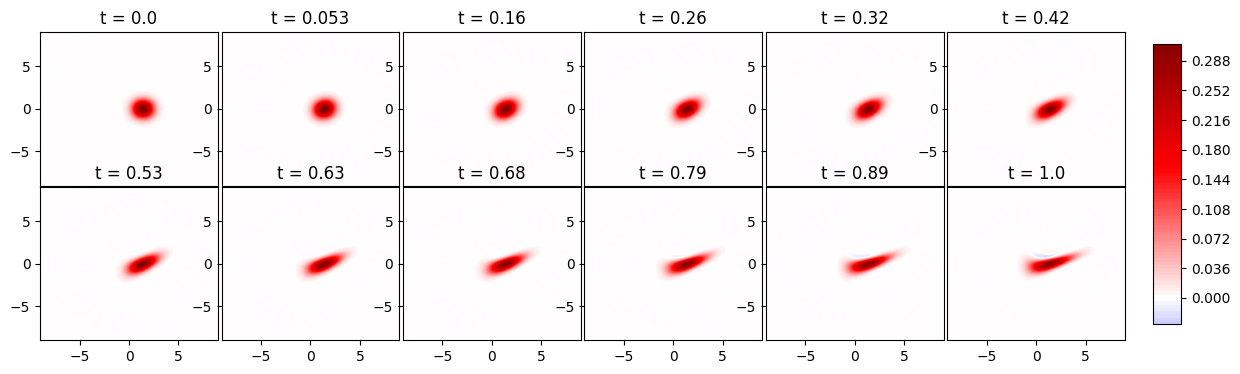

In [6]:
# create and plot based on my code

# --- 5. Initial state ---
psi_init2 = qutip.coherent(backend.dim, 1)

# --- 6. Time evolution grid ---
times2 = np.linspace(0.0, 1.0, 20)

# --- 7. Manual time evolution ---
states2 = []
U_morse_opt2 = []

for n in range(0, len(times2)):
    U_morse2 = qutip.Qobj(-1j * morse_hamiltonian * times2[n]).expm()  # compute unitary U(t) = e^{-iHt}
    psi_current2 = U_morse2 * psi_init2       # evolve the initial state
    states2.append(psi_current2)             # store state at time t
    U_morse_opt2.append(U_morse2)            # store unitary operator

result2 = FakeResult()
result2.states = states2  # type: ignore
result2.times = times2    # type: ignore

plot_wigner_fucntion(result2, 0)

